In [1]:
# first neural network with keras tutorial
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from keras import regularizers
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('creditcard2.csv', delimiter=',')

In [3]:
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.3 # 20% of the data
dataset.shape

(284807, 31)

Text(0, 0.5, 'Frequency')

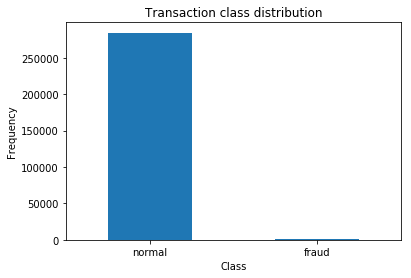

In [4]:
# Let's plot the Transaction class against the Frequency
labels = ['normal','fraud']
classes = pd.value_counts(dataset['Class'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [5]:
dataset['Time'] = StandardScaler().fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = StandardScaler().fit_transform(dataset['Amount'].values.reshape(-1, 1))

In [6]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [7]:
from sklearn.model_selection import train_test_split
# 80% for the training set and 20% for the testing set
train, test = train_test_split(dataset, test_size=TEST_PCT,random_state=RANDOM_SEED)
test, val = train_test_split(test, test_size=TEST_PCT,random_state=RANDOM_SEED)

In [8]:
train_x = train.loc[train['Class'] == 0]
train_x = train_x.drop(['Class'], axis=1)

val_y = val['Class']
val_x = val.drop(['Class'], axis=1)

test_y = test['Class']
test_x = test.drop(['Class'], axis=1)

In [9]:
print('Shapes are: Train=',train.shape,' Validation=',val.shape,' Test=',test.shape)

Shapes are: Train= (199364, 31)  Validation= (25633, 31)  Test= (59810, 31)


In [10]:
from keras.layers import Input, Dense
from keras.models import Model

In [ ]:
# this is the size of our encoded representations
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1]
encoding_dim = int(input_dim / 2) - 1
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])


In [ ]:
cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(val_x, val_x),
                    verbose=1,
                    callbacks=[cp, tb]).history

In [13]:
from sklearn.metrics import confusion_matrix, precision_recall_curve,cohen_kappa_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

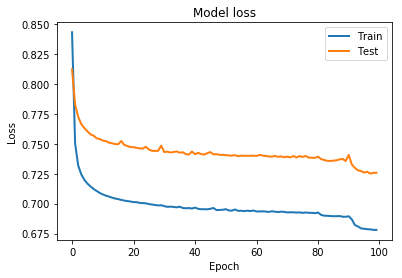

In [14]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [15]:
y_pred = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - y_pred, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': test_y})
error_df.describe()

,reconstruction_error,true_class
count,59810.000000,59810.000000
mean,0.726849,0.001939
std,3.332713,0.043997
min,0.041592,0.000000
25%,0.237124,0.000000
50%,0.370869,0.000000
75%,0.594065,0.000000
max,202.115878,1.000000


## Reconstruction error without fraud

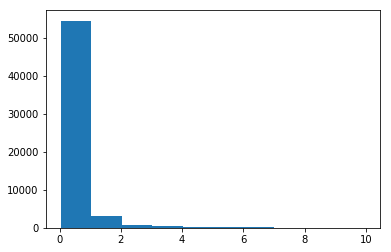

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)


## Reconstruction error with fraud

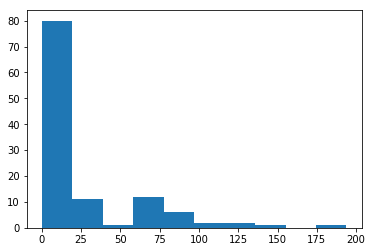

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [18]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

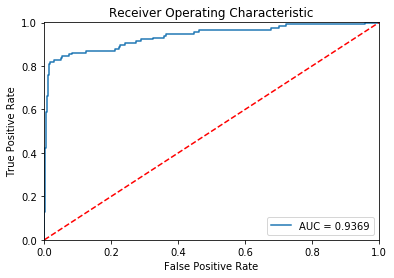

In [19]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

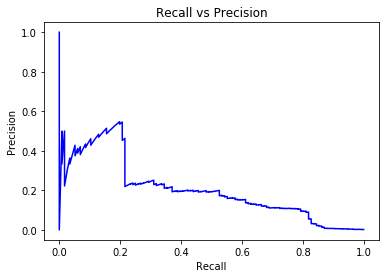

In [20]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

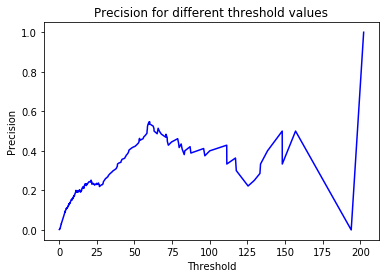

In [21]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

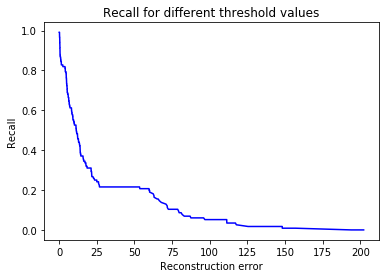

In [22]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [23]:
threshold = 2.9

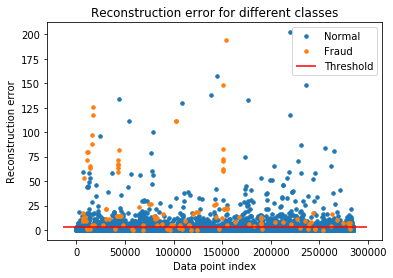

In [24]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [25]:
import seaborn as sns
LABELS = ["Normal", "Fraud"]

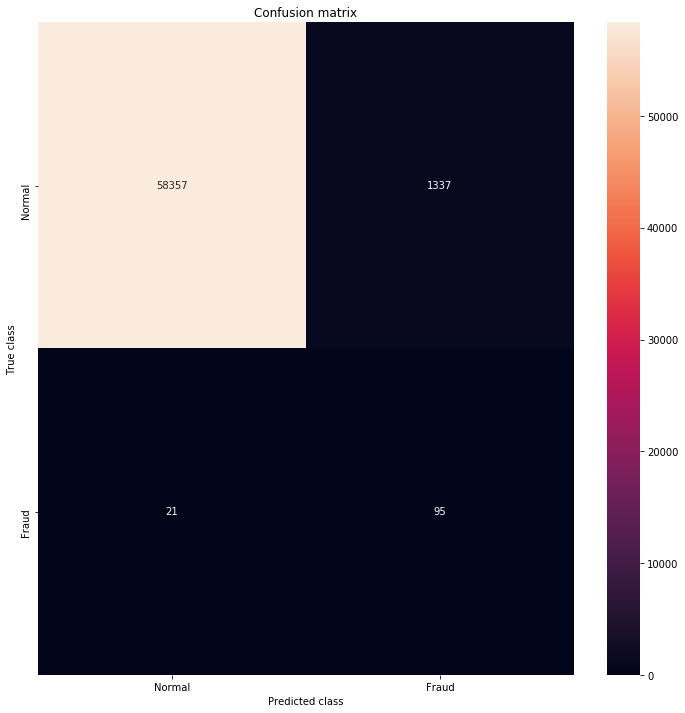

In [26]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [27]:
from sklearn.metrics import precision_score,accuracy_score
precision_score(y_true=error_df.true_class, y_pred=y_pred) 

0.06634078212290503

In [28]:
precision_score(y_true=error_df.true_class, y_pred=y_pred)
accuracy_score(y_true=error_df.true_class, y_pred=y_pred)

0.9772947667614111

In [29]:
print ("")
print ("Classification Report: ")
print (classification_report(y_true=error_df.true_class, y_pred=y_pred))

print ("")
print ("Accuracy Score: ", accuracy_score(y_true=error_df.true_class, y_pred=y_pred))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     59694
           1       0.07      0.82      0.12       116

    accuracy                           0.98     59810
   macro avg       0.53      0.90      0.56     59810
weighted avg       1.00      0.98      0.99     59810


Accuracy Score:  0.9772947667614111
